In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
%cd /content/drive/MyDrive/ML/assignment4/

/content/drive/MyDrive/ML/assignment4


In [22]:
ls

example_submission.csv  icml_face_data.csv  test.csv
fer2013.tar.gz          kaggle.json         train.csv


In [13]:
!pip install wandb

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wandb
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from PIL import Image


In [15]:
!nvidia-smi

Thu Jun  5 23:34:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [23]:
wandb.login()

True

In [24]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"Train columns: {train_df.columns.tolist()}")
print(f"Test columns: {test_df.columns.tolist()}")
print("\nFirst few rows of train:")
print(train_df.head())
print("\nFirst few rows of test:")
print(test_df.head())

Train shape: (28709, 2)
Test shape: (7178, 1)
Train columns: ['emotion', 'pixels']
Test columns: ['pixels']

First few rows of train:
   emotion                                             pixels
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...

First few rows of test:
                                              pixels
0  254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1  156 184 198 202 204 207 210 212 213 214 215 21...
2  69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3  205 203 236 157 83 158 120 116 94 86 155 180 2...
4  87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...



Emotion distribution:
Angry: 3995
Disgust: 436
Fear: 4097
Happy: 7215
Sad: 4830
Surprise: 3171
Neutral: 4965


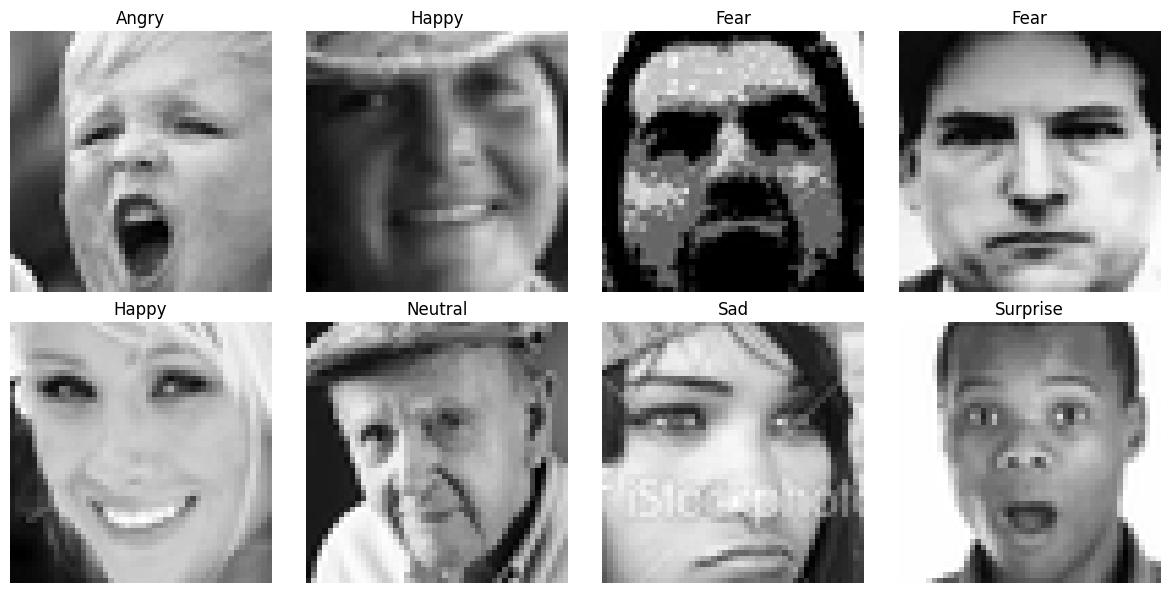

In [25]:
emotion_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy',
                 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

print(f"\nEmotion distribution:")
emotion_counts = train_df['emotion'].value_counts().sort_index()
for emotion, count in emotion_counts.items():
    print(f"{emotion_labels[emotion]}: {count}")

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(8):
    idx = np.random.randint(0, len(train_df))
    pixels = train_df.iloc[idx]['pixels']
    pixels = np.array([int(pixel) for pixel in pixels.split()])
    image = pixels.reshape(48, 48)
    emotion = train_df.iloc[idx]['emotion']

    ax = axes[i//4, i%4]
    ax.imshow(image, cmap='gray')
    ax.set_title(f"{emotion_labels[emotion]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [26]:
train_data, val_data = train_test_split(train_df, test_size=0.2,
                                        stratify=train_df['emotion'],
                                        random_state=42)
print(f"Train samples: {len(train_data)} | Validation samples: {len(val_data)}")

Train samples: 22967 | Validation samples: 5742


Baseline CNN

In [27]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class FERDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = np.array(
            list(map(int, self.data.iloc[idx]['pixels'].split()))).reshape(48, 48).astype(np.uint8)
        image = Image.fromarray(pixels)
        if self.transform:
            image = self.transform(image)
        label = self.data.iloc[idx]['emotion']
        return image, label

train_dataset = FERDataset(train_data, transform=transform)
val_dataset = FERDataset(val_data, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


class BaselineCNN(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 12 * 12)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BaselineCNN().to(device)
model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Using device: {device}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

wandb.init(
    project="fer-facial-expression",
    name="baseline-simple-cnn",
    config={
        "architecture": "Baseline CNN",
        "conv_layers": 2,
        "fc_layers": 2,
        "learning_rate": 0.001,
        "batch_size": 64,
        "epochs": 10,
        "optimizer": "Adam"
    }
)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct = 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()

    return running_loss / len(loader.dataset), 100 * correct / len(loader.dataset)

def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

    return running_loss / len(loader.dataset), 100 * correct / len(loader.dataset)

num_epochs = 10


Using device: cuda
Total parameters: 1,199,495


In [30]:
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)

    print(f"Epoch {epoch}/{num_epochs} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc
    })

print("Training complete.")
wandb.finish()


Epoch 1/10 | Train Acc: 29.66% | Val Acc: 39.72%
Epoch 2/10 | Train Acc: 38.49% | Val Acc: 43.16%
Epoch 3/10 | Train Acc: 42.16% | Val Acc: 45.68%
Epoch 4/10 | Train Acc: 45.10% | Val Acc: 47.94%
Epoch 5/10 | Train Acc: 47.83% | Val Acc: 49.01%
Epoch 6/10 | Train Acc: 49.24% | Val Acc: 50.19%
Epoch 7/10 | Train Acc: 50.59% | Val Acc: 50.59%
Epoch 8/10 | Train Acc: 52.67% | Val Acc: 50.63%
Epoch 9/10 | Train Acc: 53.98% | Val Acc: 50.51%
Epoch 10/10 | Train Acc: 55.64% | Val Acc: 52.19%
Training complete.


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_acc,▁▃▄▆▆▇▇▇▇█
val_loss,█▅▄▃▂▁▁▁▁▁
epoch,10
train_acc,55.63635
train_loss,1.14286
val_acc,52.19436
val_loss,1.30821


Adding Batch Normalization

In [31]:
class BaselineCNN_BatchNorm(nn.Module):
    def __init__(self, num_classes=7):
        super(BaselineCNN_BatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 12 * 12)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = BaselineCNN_BatchNorm().to(device)
model.apply(init_weights)

optimizer = optim.Adam(model.parameters(), lr=0.001)

wandb.init(
    project="fer-facial-expression",
    name="batchnorm-cnn",
    config={
        "architecture": "Baseline CNN with BatchNorm",
        "conv_layers": 2,
        "fc_layers": 2,
        "learning_rate": 0.001,
        "batch_size": 64,
        "epochs": 25,
        "optimizer": "Adam",
        "total_params": sum(p.numel() for p in model.parameters())
    }
)

num_epochs = 25
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_accuracy": train_acc,
        "val_loss": val_loss,
        "val_accuracy": val_acc
    })

wandb.finish()


Epoch 1/25 - Train Loss: 1.8382, Train Acc: 26.85%, Val Loss: 1.6754, Val Acc: 33.70%
Epoch 2/25 - Train Loss: 1.6545, Train Acc: 33.13%, Val Loss: 1.5236, Val Acc: 42.06%
Epoch 3/25 - Train Loss: 1.5779, Train Acc: 36.41%, Val Loss: 1.4829, Val Acc: 42.42%
Epoch 4/25 - Train Loss: 1.5374, Train Acc: 37.79%, Val Loss: 1.4377, Val Acc: 45.00%
Epoch 5/25 - Train Loss: 1.5191, Train Acc: 38.15%, Val Loss: 1.4384, Val Acc: 44.93%
Epoch 6/25 - Train Loss: 1.5017, Train Acc: 39.59%, Val Loss: 1.4332, Val Acc: 45.92%
Epoch 7/25 - Train Loss: 1.4754, Train Acc: 40.64%, Val Loss: 1.4081, Val Acc: 45.98%
Epoch 8/25 - Train Loss: 1.4622, Train Acc: 41.43%, Val Loss: 1.3923, Val Acc: 46.62%
Epoch 9/25 - Train Loss: 1.4400, Train Acc: 42.23%, Val Loss: 1.3879, Val Acc: 46.73%
Epoch 10/25 - Train Loss: 1.4335, Train Acc: 42.35%, Val Loss: 1.3869, Val Acc: 46.93%
Epoch 11/25 - Train Loss: 1.4134, Train Acc: 43.35%, Val Loss: 1.3685, Val Acc: 47.35%
Epoch 12/25 - Train Loss: 1.3966, Train Acc: 44.38%,

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
train_accuracy,▁▃▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█████
train_loss,█▆▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██▇████
val_loss,█▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂
epoch,25
train_accuracy,50.01524
train_loss,1.25238
val_accuracy,49.79101
val_loss,1.35873


In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(48, scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class FERDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = np.array(list(map(int, self.data.iloc[idx]['pixels'].split()))).reshape(48, 48).astype(np.uint8)
        image = Image.fromarray(pixels)
        if self.transform:
            image = self.transform(image)
        label = int(self.data.iloc[idx]['emotion'])
        return image, label

train_dataset = FERDataset(train_data, transform=train_transform)
val_dataset = FERDataset(val_data, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


class BaselineCNN_BatchNorm_Dropout(nn.Module):
    def __init__(self, num_classes=7):
        super(BaselineCNN_BatchNorm_Dropout, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout_conv = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout_conv(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout_conv(x)
        x = x.view(-1, 64 * 12 * 12)
        x = self.dropout_fc(x)
        x = F.relu(self.bn3(self.fc1(x)))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x


def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct = 0.0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = 100. * correct / len(loader.dataset)
    return epoch_loss, epoch_acc

def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss, correct = 0.0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = 100. * correct / len(loader.dataset)
    return epoch_loss, epoch_acc

model = BaselineCNN_BatchNorm_Dropout().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


wandb.init(
    project="fer-facial-expression",
    name="best-so-far-batchnorm-dropout-cnn",
    config={
        "architecture": "BaselineCNN_BatchNorm_Dropout",
        "learning_rate": 0.001,
        "batch_size": 64,
        "epochs": 25,
        "optimizer": "Adam",
        "total_params": sum(p.numel() for p in model.parameters())
    }
)

num_epochs = 25
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)
    print(f"Epoch {epoch}/{num_epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_accuracy": train_acc,
        "val_loss": val_loss,
        "val_accuracy": val_acc
    })

wandb.finish()
print("Training Complete")


Experiment 2

In [46]:
class BetterCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(BetterCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout_fc = nn.Dropout(0.3)
        self.fc1 = nn.Linear(128 * 6 * 6, 256)
        self.bn_fc = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 6 * 6)
        x = F.relu(self.bn_fc(self.fc1(x)))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = BetterCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

wandb.init(
    project="fer-facial-expression",
    name="better-cnn-with-aug-bn-scheduler",
    config={
        "architecture": "BetterCNN",
        "conv_layers": 3,
        "fc_layers": 2,
        "learning_rate": 0.001,
        "batch_size": 64,
        "epochs": 20,
        "optimizer": "Adam",
        "scheduler": "StepLR",
        "dropout_fc": 0.3,
        "data_aug": True,
        "total_params": sum(p.numel() for p in model.parameters())
    }
)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    return running_loss / total, 100. * correct / total

def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return running_loss / total, 100. * correct / total

num_epochs = 20
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)
    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_accuracy": train_acc,
        "val_loss": val_loss,
        "val_accuracy": val_acc,
        "lr": scheduler.get_last_lr()[0]
    })

print("Training complete.")

Using device: cuda


Epoch 1/20 | Train Loss: 1.6285 | Train Acc: 35.87% | Val Loss: 1.5429 | Val Acc: 40.82%
Epoch 2/20 | Train Loss: 1.4101 | Train Acc: 45.84% | Val Loss: 1.2763 | Val Acc: 50.85%
Epoch 3/20 | Train Loss: 1.3326 | Train Acc: 48.99% | Val Loss: 1.1951 | Val Acc: 54.23%
Epoch 4/20 | Train Loss: 1.2831 | Train Acc: 51.16% | Val Loss: 1.1588 | Val Acc: 56.01%
Epoch 5/20 | Train Loss: 1.2514 | Train Acc: 52.46% | Val Loss: 1.1204 | Val Acc: 57.05%
Epoch 6/20 | Train Loss: 1.1896 | Train Acc: 54.88% | Val Loss: 1.0634 | Val Acc: 59.65%
Epoch 7/20 | Train Loss: 1.1688 | Train Acc: 55.79% | Val Loss: 1.0649 | Val Acc: 59.98%
Epoch 8/20 | Train Loss: 1.1493 | Train Acc: 56.71% | Val Loss: 1.0617 | Val Acc: 59.80%
Epoch 9/20 | Train Loss: 1.1375 | Train Acc: 57.33% | Val Loss: 1.0442 | Val Acc: 60.45%
Epoch 10/20 | Train Loss: 1.1228 | Train Acc: 57.46% | Val Loss: 1.0360 | Val Acc: 61.06%
Epoch 11/20 | Train Loss: 1.0969 | Train Acc: 58.58% | Val Loss: 1.0253 | Val Acc: 61.11%
Epoch 12/20 | Train

In [44]:
class TestFERDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = np.fromstring(self.dataframe.iloc[idx]['pixels'], sep=' ', dtype=np.uint8).reshape(48, 48)
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image

test_df = pd.read_csv('test.csv')

test_dataset = TestFERDataset(test_df, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.eval()
all_preds = []

with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())

submission = pd.DataFrame({'emotion': all_preds})
submission.to_csv('submission.csv', index=False)

print("Test predictions complete and saved to submission.csv")


Test predictions complete and saved to submission.csv
